# Portfolio Optimization

**Portfolio**: A portfolio is a collection of financial instruments like stocks, bonds, commodities, cash and cash equivalents , as well as their fund counterparts. [Investopedia]

**Returns**: It refers to the gain or loss on our asset/portfolio over a fixed time frame. In this analysis, we make a return as the percentage change in the closing price of the asset over the previous day’s closing price. We will compute the returns using .pct_change() function in python. #https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/

**Portfolio optimization**: The process of creating a portfolio of assets, for which your investment has the maximum return and minimum risk.

But how do we decide out of an infinite possible combinations for portfolios, the one which is optimum?

**Modern Portfolio Theory**, or also known as mean-variance analysis is a mathematical process which allows the user to maximize returns for a given risk level.

* It was formulated by H. Markowitz and while it is not the only optimization technique known, it is the most widely used.

* MPT assumes that all investors are risk-averse, i.e, if there is a choice between low risk and high risk portfolios with the same returns, an investor will choose one with the low risk.

Specifically, given the historical data of $n$ stocks:
* $\tilde{r}_i$: Reward from stock $i$ (random variable)
* $\mu_i = {\rm E}(\tilde{r}_i)$: expected reward from stock $i$
* ${\rm Var}(\tilde{r}_i):$ variance in reward from stock $i$
* $\sigma_{ij} = {\rm E}((\tilde{r}_i - \mu_i)(\tilde{r}_j - \mu_j)) = {\rm  Cov}(\tilde{r}_i,\tilde{r}_j)$. Note that $\sigma_{ii} = {\rm Var}(\tilde{r}_i):$
* Budget $B$, target $\beta$ on expected portfolio reward

we want to decide the amount to invest in stock $i$---denoted as $x_i$---to minimize total portfolio variance so that:
* expected reward of total portfolio is above target β
* total amount invested stay within our budget

(Note that we do not consider short sales here)

We can formulate the portfolio problem as follows:

$$
\begin{align}
\min\ & \boldsymbol{x}^\top \boldsymbol{\Sigma} \boldsymbol{x}\\
\mbox{s.t.}\ & \boldsymbol{\mu}^\top \boldsymbol{x} \geq \beta\\
&\boldsymbol{1}^\top \boldsymbol{x} \leq B\\
&\boldsymbol{x} \leq \boldsymbol{1}\\
&\boldsymbol{x} \geq \boldsymbol{0}
\end{align}
$$

Now let's go through some fundamental terms in portfolio optimization step by step and solve the above model at the end. 

In [1]:
import pandas as pd
import numpy as np
import pickle
import folium
from folium.plugins import BeautifyIcon
import matplotlib.pyplot as plt
from pandas_datareader import data

import rsome as rso
from rsome import ro
from rsome import grb_solver as grb

### Step 1 Pull the stock price data from yahoo finance

The first step is to is to pull the required data from a verified site such as Yahoo or Quandl. The example below uses Yahoo and the dates for which we will be pulling the data is from 1st January, 2010 to 31st December, 2019. Note that we only use the closing price `"Adj Close"`.

In [2]:
# Read Data
Stock_data = data.DataReader(['AAPL', 'FB'], 'yahoo', start='2018/01/01', end='2019/12/31')
Stock_data.head()

Attributes  Adj Close                  Close                   High  \
Symbols          AAPL          FB       AAPL          FB       AAPL   
Date                                                                  
2018-01-02  41.135754  181.419998  43.064999  181.419998  43.075001   
2018-01-03  41.128590  184.669998  43.057499  184.669998  43.637501   
2018-01-04  41.319633  184.330002  43.257500  184.330002  43.367500   
2018-01-05  41.790066  186.850006  43.750000  186.850006  43.842499   
2018-01-08  41.634846  188.279999  43.587502  188.279999  43.902500   

Attributes                    Low                   Open              \
Symbols             FB       AAPL          FB       AAPL          FB   
Date                                                                   
2018-01-02  181.580002  42.314999  177.550003  42.540001  177.679993   
2018-01-03  184.779999  42.990002  181.330002  43.132500  181.880005   
2018-01-04  186.210007  43.020000  184.100006  43.134998  184.899994   
2018-01-05  186.899994  43.262501  184.929993  43.360001  185.589996   
2018-01-08  188.899994  43.482498  186.330002  43.587502  187.199997   

Attributes       Volume              
Symbols            AAPL          FB  
Date                                 
2018-01-02  102223600.0  18151900.0  
2018-01-03  118071600.0  16886600.0  
2018-01-04   89738400.0  13880900.0  
2018-01-05   94640000.0  13574500.0  
2018-01-08   82271200.0  17994700.0

In [2]:
# https://amangupta16.medium.com/portfolio-optimization-using-python-part-1-2-9fd80097a606
# Creating a list of Stock Tickers
stocks = ['HSBC','JPM','AAPL','WMT','AMZN','MSFT']
num_stocks = len(stocks)

price_data = pd.DataFrame()
# Pulling closing price   
for stock in stocks:
    price_data[stock] = data.DataReader(stock, data_source = 'yahoo', start = '2010-1-1', end = '2019-12-31')['Adj Close']


In [3]:
price_data

,HSBC,JPM,AAPL,WMT,AMZN,MSFT
Date,,,,,,
2009-12-31,30.848890,30.619156,6.444383,40.011978,134.520004,23.493389
2010-01-04,31.513536,31.524036,6.544689,40.595860,133.899994,23.855661
2010-01-05,32.016064,32.134655,6.556003,40.191628,134.690002,23.863363
2010-01-06,32.053890,32.311226,6.451724,40.101791,132.250000,23.716915
2010-01-07,31.951218,32.951279,6.439794,40.124237,130.000000,23.470272
...,...,...,...,...,...,...
2019-12-24,35.171288,128.735031,69.938210,115.261894,1789.209961,154.117081
2019-12-26,35.380375,130.101151,71.325806,115.271530,1868.770020,155.380295
2019-12-27,35.453098,130.194717,71.298729,115.339050,1869.800049,155.664307


Plotting normalized returns to have a visualization of the data

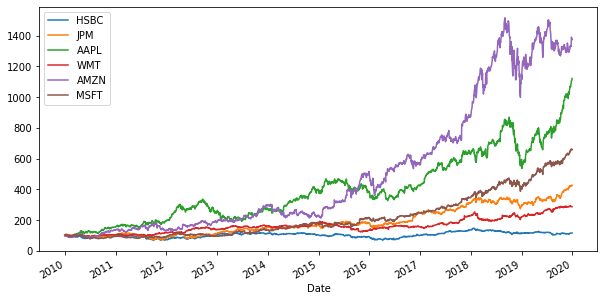

In [4]:
(price_data / price_data.iloc[0] * 100).plot(figsize=(10, 5))
plt.show()

### Step 2: Calculate percentage change (dayly return) and average return in stock prices

Next, we calculate the percentage change in stock prices everyday. You will notice that that we take the log of percentage change.

But why take log?

The reason for this is that log of the returns is time additive.

That is, If $r_{13}$ is the returns for time between $t_3$ and $t_1$. $r_{12}$ is the returns between $t_1$ and $t_2$ and $r_{23}$ is the returns between $t_2$ and $t_3$.

Then, $\log(r_{13}) = \log(r_{12}) + \log(r_{23})$

For example:,
If $p_1 = 100, p_2 = 110$ and $p_3 = 120$, where $p_1$ is price of stock in time 1

Then:

$$ \log(r_{12}) = \ln(p2/p1) = \ln(110/100) = 9.53\%, $$

$$ \log(r_{23}) = \ln(120/110) = 8.7\%$$ 
and

$$ \log(r_{13}) = \log(r_{12}) + \log(r_{23}) = 9.53 + 8.7 = 18.23\%,$$ 

which is same as $\ln(120/100)$.

This means a log change of +0.1 today and then -0.1 tomorrow will give you the same value of stock as yesterday. This is not true if you simply compute percentage change.

It is common practice in portfolio optimization to take log of returns for calculations of covariance and correlation.

This can be easily achieved by using `pct_change()`. 

In [6]:
np.log(110/100)

0.09531017980432493

                HSBC       JPM      AAPL       WMT      AMZN      MSFT
Date                                                                  
2009-12-31       NaN       NaN       NaN       NaN       NaN       NaN
2010-01-04  0.021545  0.029553  0.015565  0.014593 -0.004609  0.015420
2010-01-05  0.015946  0.019370  0.001729 -0.009957  0.005900  0.000323
2010-01-06  0.001181  0.005495 -0.015906 -0.002235 -0.018116 -0.006137
2010-01-07 -0.003203  0.019809 -0.001849  0.000560 -0.017013 -0.010399


<function matplotlib.pyplot.show(close=None, block=None)>

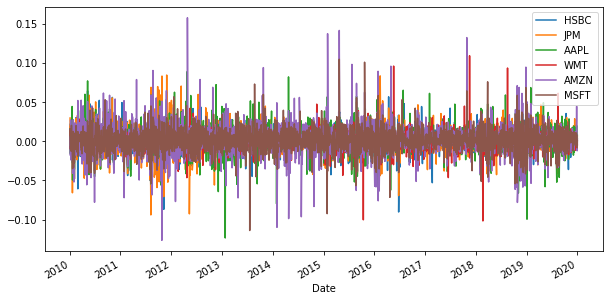

In [9]:
# pf_data pct change
day_returns = price_data.pct_change()
print(day_returns.head(5))
day_returns.plot(figsize=(10,5))
plt.show

In [10]:
avg_day_return = day_returns.mean()
avg_day_return

HSBC    0.000146
JPM     0.000701
AAPL    0.001093
WMT     0.000477
AMZN    0.001231
MSFT    0.000851
dtype: float64

In [11]:
avg_year_return = price_data.resample('Y').last().pct_change().mean()
avg_year_return

HSBC    0.034192
JPM     0.175487
AAPL    0.301383
WMT     0.127535
AMZN    0.347834
MSFT    0.223475
dtype: float64

### Step 3: Calculate variance/covariance in stock prices

The variance in prices of stocks are an important indicator of how volatile this investment will be (how returns can fluctuate).

It can be calculated for each company by using built in `.var()` function. Under the hood, the formula implemented by this function is given by:
$
\sigma^2 = \sum_{i = 1}^{N}(x_i - \bar{x})^2/(N - 1)
$

The covariance between Apple and Apple, or Nike and Nike is the variance of that asset.

The next step is to create the correlation matrix. Correlation ranges from -1 to 1.

A correlation of -1 means negative relation, i.e, if correlation between Asset A and Asset B is -1, if Asset A increases, Asset B decreases.

A correlation of +1 means positive relation, i.e, if correlation between Asset A and Asset B is 1, if Asset A increases, Asset B increases.

A correlation of 0 means no relation, i.e, if correlation between Asset A and Asset B is 0, they dont have any effect on each other.

In [12]:
Variance = day_returns.var()
Variance.head(5) 

HSBC    0.000180
JPM     0.000249
AAPL    0.000263
WMT     0.000118
AMZN    0.000381
dtype: float64

In [13]:
price_data.cov()

,HSBC,JPM,AAPL,WMT,AMZN,MSFT
HSBC,24.713069,94.963934,42.115481,62.302395,1742.277135,99.306897
JPM,94.963934,757.543085,375.177988,475.727914,15391.473498,915.407450
AAPL,42.115481,375.177988,201.013888,249.719211,7739.414935,468.120769
WMT,62.302395,475.727914,249.719211,360.967278,9762.977309,606.505751
AMZN,1742.277135,15391.473498,7739.414935,9762.977309,336894.083775,19528.151981
MSFT,99.306897,915.407450,468.120769,606.505751,19528.151981,1188.225653


In [14]:
Covariance = day_returns.cov()
Covariance.head(5)

,HSBC,JPM,AAPL,WMT,AMZN,MSFT
HSBC,0.000180,0.000137,0.000079,0.000038,0.000091,0.000087
JPM,0.000137,0.000249,0.000095,0.000051,0.000107,0.000107
AAPL,0.000079,0.000095,0.000263,0.000040,0.000126,0.000106
WMT,0.000038,0.000051,0.000040,0.000118,0.000043,0.000048
AMZN,0.000091,0.000107,0.000126,0.000043,0.000381,0.000136


In [15]:
Correlation = day_returns.corr()
Correlation.head(5)

,HSBC,JPM,AAPL,WMT,AMZN,MSFT
HSBC,1.000000,0.647931,0.363095,0.264114,0.349327,0.454687
JPM,0.647931,1.000000,0.370739,0.297848,0.346938,0.473202
AAPL,0.363095,0.370739,1.000000,0.225690,0.397260,0.457443
WMT,0.264114,0.297848,0.225690,1.000000,0.203942,0.307232
AMZN,0.349327,0.346938,0.397260,0.203942,1.000000,0.488357


We can also calculate the standard deviation which is also called the **Volatility**.

But what we get from square root of variance is the daily standard deviation. To convert it to annual standard deviation we multiply the variance by 250 because there are 250 trading days in a year.

In [16]:
Annual_sd = day_returns.std()*np.sqrt(250)
Annual_sd

HSBC    0.211862
JPM     0.249744
AAPL    0.256449
WMT     0.171824
AMZN    0.308496
MSFT    0.226302
dtype: float64

### Step 4: Solve the optimization model

Note that in RSOME, $\boldsymbol{x}^\top \boldsymbol{Q} \boldsymbol{x}$ can be calculated by using `rso.quad(x,Q)` function and 
$$
\boldsymbol{x}^\top \boldsymbol{Q} \boldsymbol{x} = 0.5 * \mbox{rso.quad}(x,Q)
$$

In [17]:
def MTZ(mu, Sigma, beta):
    m = ro.Model('portfolio')
    N = len(mu)
    x = m.dvar(N)

    m.min( 0.5*rso.quad(x, Sigma) )

    m.st( mu @ x >= beta )
    m.st( x.sum() == 1, x >= 0)

    m.solve(grb, display = False)

    return np.round( x.get(), 4 ), m.get()
    

In [18]:
Sigma = Covariance.values
mu = avg_year_return.values
beta = 0.2
x_star, obj_star = MTZ(mu, Sigma, beta)
print(x_star, obj_star)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-14
[0.0199 0.0597 0.1921 0.4815 0.1176 0.1292] 4.551057647650403e-05


#### An alternative model

In [19]:
def MTZ1(mu, Sigma, beta):
    m = ro.Model('portfolio')
    N = len(mu)
    x = m.dvar(N)

    m.max( mu @ x )

    m.st( rso.quad(x, Sigma) <= 0.0002 )
    m.st( x.sum() == 1, x >= 0, x <= 1)

    m.solve(grb, display = False)

    return np.round( x.get(), 4 ), m.get()

In [20]:
x_star1, obj_star1 = MTZ1(mu, Sigma, beta)
print(x_star1, obj_star1)

[0.     0.     0.4966 0.0176 0.4138 0.072 ] 0.3119406112299466


### Step 5: Analyze the solution

After obtaining the optimal weights, we can evaluate the expected (annual) return and standard deviation of the portfolio. Specifically, given optimal weights $\boldsymbol{x}^*$ and the expected annual return of all the stocks, denoted as $\boldsymbol{\mu}$, the expected annual return of the portfolio is:

$$ \mbox{Expected annual return} = \boldsymbol{x}^\top \boldsymbol{\mu}$$


#### Calculate the expected annual return for the optimal weight

In [24]:
mu @ x_star

0.2002389806040363

In [25]:
np.sqrt(x_star.T @ Sigma @ x_star)

0.009530976233298016

### Step 6: Sensitivity analysis

What if we set different target $\beta$? For example, $\beta \in \{0.01, 0.02, 0.03, \ldots, 0.3\}$. We then need to do the sensitivity analysis. 

In other words, we solve the problem for each $\beta$ and evaluate the corresponding solution. 

In [21]:
M = 30
beta_all = [0.01 + i*0.01 for i in range(M)]

In [22]:
ex_return = []
sd_return = []
for i in range(M):
    x_star, obj_star = MTZ(mu, Sigma, beta_all[i])
    ex_return.append(mu @ x_star)
    sd_return.append(np.sqrt(x_star.T @ Sigma @ x_star * 250))

In [23]:
assets = pd.DataFrame(
    {'Target': beta_all[0:len(ex_return)],
     'Returns': ex_return,
     'Volatility': sd_return
    }) # Creating a table for visualising returns and volatility of assets

#### Plot the efficience frontier

Efficient frontier is a graph with ‘returns’ on the Y-axis and ‘volatility’ on the X-axis. It shows us the maximum return we can get for a set level of volatility, or conversely, the volatility that we need to accept for certain level of returns.

Text(0, 0.5, 'Return')

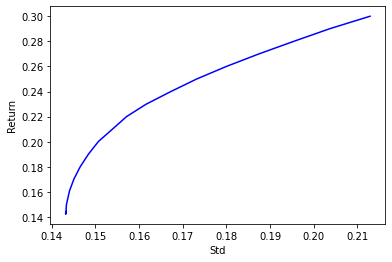

In [24]:
plt.plot(sd_return, ex_return, color = 'b')
plt.xlabel('Std')
plt.ylabel('Return')

We found the portfolio with minimum volatility, but you will notice that the return on this portfolio is pretty low. Any sensible investor wants to maximize his return, even if it is a tradeoff with some level of risk.

The question arises that how do we find this optimal risky portfolio and finally optimize our portfolio to the maximum?

This is done by using a parameter called the Sharpe Ratio.

#### Sharpe Ratio

The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. Volatility is a measure of the price fluctuations of an asset or portfolio.

The risk-free rate of return is the return on an investment with zero risk, meaning it’s the return investors could expect for taking no risk.
The optimal risky portfolio is the one with the highest Sharpe ratio. The formula for this ratio is:

$
\mbox{Shape Ratio} = \frac{R_p - R_f}{\sigma_p}
$
where $R_p$ is the return and $R_f$ is the risk free return. 

In [60]:
assets['Shape_Ratio'] = (assets['Returns'] - 0.01)/assets['Volatility']

<AxesSubplot:>

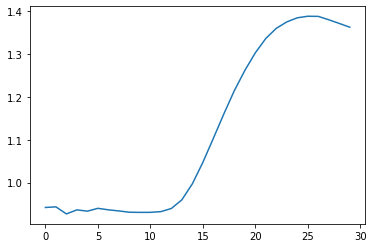

In [61]:
assets['Shape_Ratio'].plot()

In [62]:
assets['Target'][ assets['Shape_Ratio'].idxmax() ]

0.26

In [63]:
assets

,Target,Returns,Volatility,Shape_Ratio
0,0.01,0.144899,0.143262,0.941623
1,0.02,0.145102,0.143258,0.943072
2,0.03,0.142681,0.143199,0.926550
3,0.04,0.144105,0.143276,0.935994
4,0.05,0.143637,0.143233,0.933000
5,0.06,0.144608,0.143257,0.939627
6,0.07,0.144079,0.143231,0.936104
7,0.08,0.143711,0.143230,0.933534
8,0.09,0.143252,0.143204,0.930504
9,0.10,0.143210,0.143215,0.930140
